In [ ]:
from PIL import Image
from PIL import Image
import os
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, Compose, Normalize, ToTensor, ToPILImage
from transformers import ViTImageProcessor
from transformers import AutoModelForImageClassification
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
import torch_directml
from scores import score_in_details
import shutil

In [13]:
dml = torch_directml.device()

In [ ]:
class MyDataset(Dataset):

    def __init__(self, ds, processor):

        self.ds = ds
        self.processor = processor
        self.normalize = Normalize(mean=self.processor.image_mean, std=self.processor.image_std)
        self.size = (self.processor.size["shortest_edge"]
                if "shortest_edge" in self.processor.size
                else (self.processor.size["height"], self.processor.size["width"]))

        self.transform = Compose([Resize(self.size), ToTensor(), self.normalize, ToPILImage()])


    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        image_path = self.ds[idx][0]
        label = self.ds[idx][1]
        image = self.transform(Image.open(image_path).convert("RGB"))
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        return {"pixel_values": pixel_values.squeeze(),
                "label": label,
                "path": image_path}

In [ ]:
checkpoint = 'google/vit-base-patch16-224'
image_processor = ViTImageProcessor.from_pretrained(checkpoint)
base_model = AutoModelForImageClassification.from_pretrained(checkpoint, num_labels=2, ignore_mismatched_sizes=True)
base_model.classifier = nn.Sequential(nn.Linear(in_features=768, out_features=256, bias=True),
                                      nn.Linear(in_features=256, out_features=2, bias=True))

In [ ]:
model_path = "../trained-models/vit_custom.pt"
base_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)
base_model = base_model.to(dml)

In [12]:
test_dataset = ImageFolder(root="../splitted/test")
test_ds = MyDataset(ds=test_dataset.imgs, processor=image_processor)
test_loader = DataLoader(test_ds, batch_size=20, drop_last=True, shuffle=False)

In [14]:
def get_predictions():
    softmax = nn.Softmax(dim=1)
    base_model.eval()
    predictions = []
    real_values = []
    pred_probas = []
    misclassified = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs = batch['pixel_values'].to(dml)
            labels = batch['label']
            path = batch['path']

            outputs = softmax(base_model(inputs).logits)

            _, preds = torch.max(outputs, dim = 1)
            for probs in outputs.cpu():
                pred_probas.append(list(probs.numpy()))

            preds = preds.cpu().numpy()
            labels = labels.numpy()

            predictions.extend(preds)
            real_values.extend(labels)

            for ind, (actual, pred) in enumerate(zip(labels, preds)):
                if actual != pred:
                    misclassified.append((path[ind], actual, pred))

    return predictions, real_values, pred_probas, misclassified

In [15]:
pred, real, probas, misclassified = get_predictions()
print(classification_report(real, pred, digits=6))

  0%|          | 0/943 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0   0.942350  0.959383  0.950790      4924
           1   0.985556  0.979262  0.982399     13936

    accuracy                       0.974072     18860
   macro avg   0.963953  0.969322  0.966595     18860
weighted avg   0.974276  0.974072  0.974147     18860



Accuracy: 97.40721102863202%
Precision: 0.9742760012071041
Recall: 0.9740721102863202
F1-score: 0.9741466922204332
MCC-score: 0.9332601977198802
ROC AUC score: 0.8654855395000565




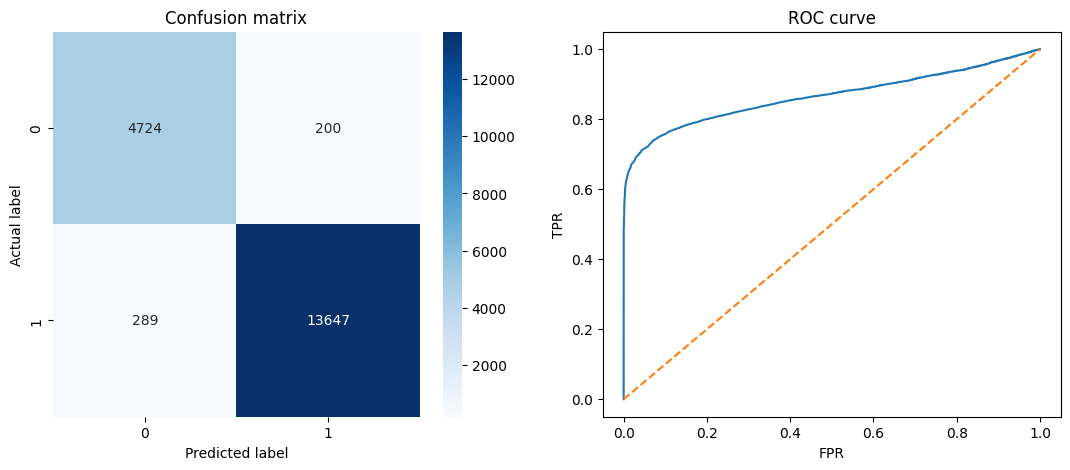

In [16]:
score_in_details(pred=pred, real=real, probas=probas)

In [17]:
dest = "../images/misclassified-new/vit-custom"

if not os.path.exists(dest):
  os.mkdir(dest)

for path, actual, predictd in tqdm(misclassified):
  img_name = path.split("\\")[-1].split(".")[0]
  ext = path.split(".")[-1]
  shutil.copy(path, os.path.join(dest, f"{img_name}_{actual}_{predictd}.{ext}"))

  0%|          | 0/489 [00:00<?, ?it/s]